## Physics Informed Neural Networks to Approximate Solution of PDEs

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)


class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """

    def __init__(self):
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 0.1).sample((49, 800))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)

    def forward(self):
        Ts = self.weights
        return Ts

class FDopts:
    def __init__(self):
        # PDE parameters
        self.alpha_f = 0.005
        self.h_f = 5.0
        self.T_hot = 4.0
        self.T_cold = 1.0
        self.T_0 = 1.0
        # solid temperature
        self.pred_Ts = Model()
        self.pred_Tf = torch.full([51, 801], self.T_0, dtype=torch.float)

        # FD parameter
        self.dx = torch.tensor(0.02, dtype= torch.float)
        self.dt = torch.tensor(0.01, dtype= torch.float)
        self.nx = 49
        self.time, self.coord, self.true_Tf = self.get_measurement_data()
        self.true_Tf.requires_grad = True
        self.time = self.time[0,:]
        self.ind = 1

    def get_measurement_data(self):  # sensor_data[:, 0] -> t; sensor_data[:, 1] -> x
        sensor_data = pd.read_table('DataSolution.txt', sep=',').values
        time = torch.tensor(sensor_data[:, 0:1], dtype=torch.float).reshape(49, 800)
        coord = torch.tensor(sensor_data[:, 1:2], dtype=torch.float).reshape(49, 800)
        value = torch.tensor(sensor_data[:, 2:3], dtype=torch.float).reshape(49, 800)

        return time, coord, value

    def charging(self, tmax):
        Uf = 1
        n = self.nx + 1
        A = torch.zeros(n + 1, n + 1)
        A[0,0] = 1
        A[n,n] = 1
        A[n, n-1] = -1
        for i in range(1,n):
            A[i, i-1] = -self.alpha_f/self.dx**2 - Uf/2/self.dx
            A[i, i] = 1/self.dt + 2*self.alpha_f/self.dx**2 + self.h_f
            A[i, i+1] = Uf/2/self.dx - self.alpha_f/self.dx**2

        while(self.time[self.ind - 1] < tmax):
            b = torch.zeros(n+1)
            b[0] = self.T_hot
            b[-1] = 0
            b[1:-1] = self.h_f * self.pred_Ts.forward()[:, self.ind - 1] + 1/self.dt * self.pred_Tf[1:-1, self.ind - 1]
            self.pred_Tf[:, self.ind] = torch.linalg.solve(A, b)
            self.ind += 1

    def discharging(self, tmax):
        Uf = -1
        n = self.nx + 1
        A = torch.zeros(n + 1, n + 1)
        A[0, 0] = 1
        A[0, 1] = -1
        A[n, n] = 1
        for i in range(1,n):
            A[i, i-1] = -self.alpha_f/self.dx**2 - Uf/2/self.dx
            A[i, i] = 1/self.dt + 2*self.alpha_f/self.dx**2 + self.h_f
            A[i, i+1] = Uf/2/self.dx - self.alpha_f/self.dx**2

        while (self.time[self.ind - 1] < tmax):
            b = torch.zeros(n + 1)
            b[0] = 0
            b[-1] = self.T_cold
            b[1:-1] = self.h_f * self.pred_Ts.forward()[:, self.ind - 1] + 1 / self.dt * self.pred_Tf[1:-1, self.ind - 1]
            self.pred_Tf[:, self.ind] = torch.linalg.solve(A, b)
            self.ind += 1

    def idle(self, tmax):
        Uf = 0
        n = self.nx + 1
        A = torch.zeros(n + 1, n + 1)
        A[0, 0] = 1
        A[0, 1] = -1
        A[n, n] = 1
        A[n, n-1] = -1
        for i in range(1,n):
            A[i, i-1] = -self.alpha_f/self.dx**2 - Uf/2/self.dx
            A[i, i] = 1/self.dt + 2*self.alpha_f/self.dx**2 + self.h_f
            A[i, i+1] = Uf/2/self.dx - self.alpha_f/self.dx**2

        while (self.time[self.ind - 1] < tmax):
            b = torch.zeros(n + 1)
            b[0] = 0
            b[-1] = 0
            b[1:-1] = self.h_f * self.pred_Ts.forward()[:, self.ind - 1] + 1 / self.dt * self.pred_Tf[1:-1, self.ind - 1]
            self.pred_Tf[:, self.ind] = torch.linalg.solve(A, b)
            self.ind += 1

    def compute_loss(self, verbose = True):
        self.pred_Tf = torch.full([51, 801], self.T_0, dtype=torch.float)
        self.ind = 1
        self.charging(1)
        self.idle(2)
        self.discharging(3)
        self.idle(4)
        self.charging(5)
        self.idle(6)
        self.discharging(7)
        self.idle(8)

        r_int = self.pred_Tf[1:-1,1:] - self.true_Tf
        loss = torch.mean(abs(r_int) ** 2)

        if verbose: print("Total loss: ", round(loss.item(), 4))

        return loss

    def optimize(self, num_epochs, optimizer, verbose=True):
        history = list()
        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")
            def closure():
                optimizer.zero_grad()
                loss = self.compute_loss(verbose=verbose)
                loss.backward()
                history.append(loss.item())
                return loss

            optimizer.step(closure = closure)

        print('Final Loss: ', history[-1])





FDopt = FDopts()
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(FDopt.pred_Ts.parameters(),
                              lr=float(0.5),
                              max_iter=1000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(FDopt.pred_Ts.parameters(),
                            lr=float(0.5))

FDopt.optimize(n_epochs,optimizer_LBFGS)




################################  0  ################################
Total loss:  1.2087
Total loss:  1.2087
Total loss:  1.2085
Total loss:  1.2071
Total loss:  1.2
Total loss:  1.1236
Total loss:  0.5003
Total loss:  0.1316
Total loss:  0.0355
Total loss:  0.0104
Total loss:  0.0037
Total loss:  0.0017
Total loss:  0.0011
Total loss:  0.0008
Total loss:  0.0006
Total loss:  0.0005
Total loss:  0.0004
Total loss:  0.0003
Total loss:  0.0003
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0002
Total loss:  0.0001
Total loss:  0.0001
Total loss:  0.0001
Total loss:  0.0001
Total loss:  

In [3]:
time, coord, value = FDopt.get_measurement_data()

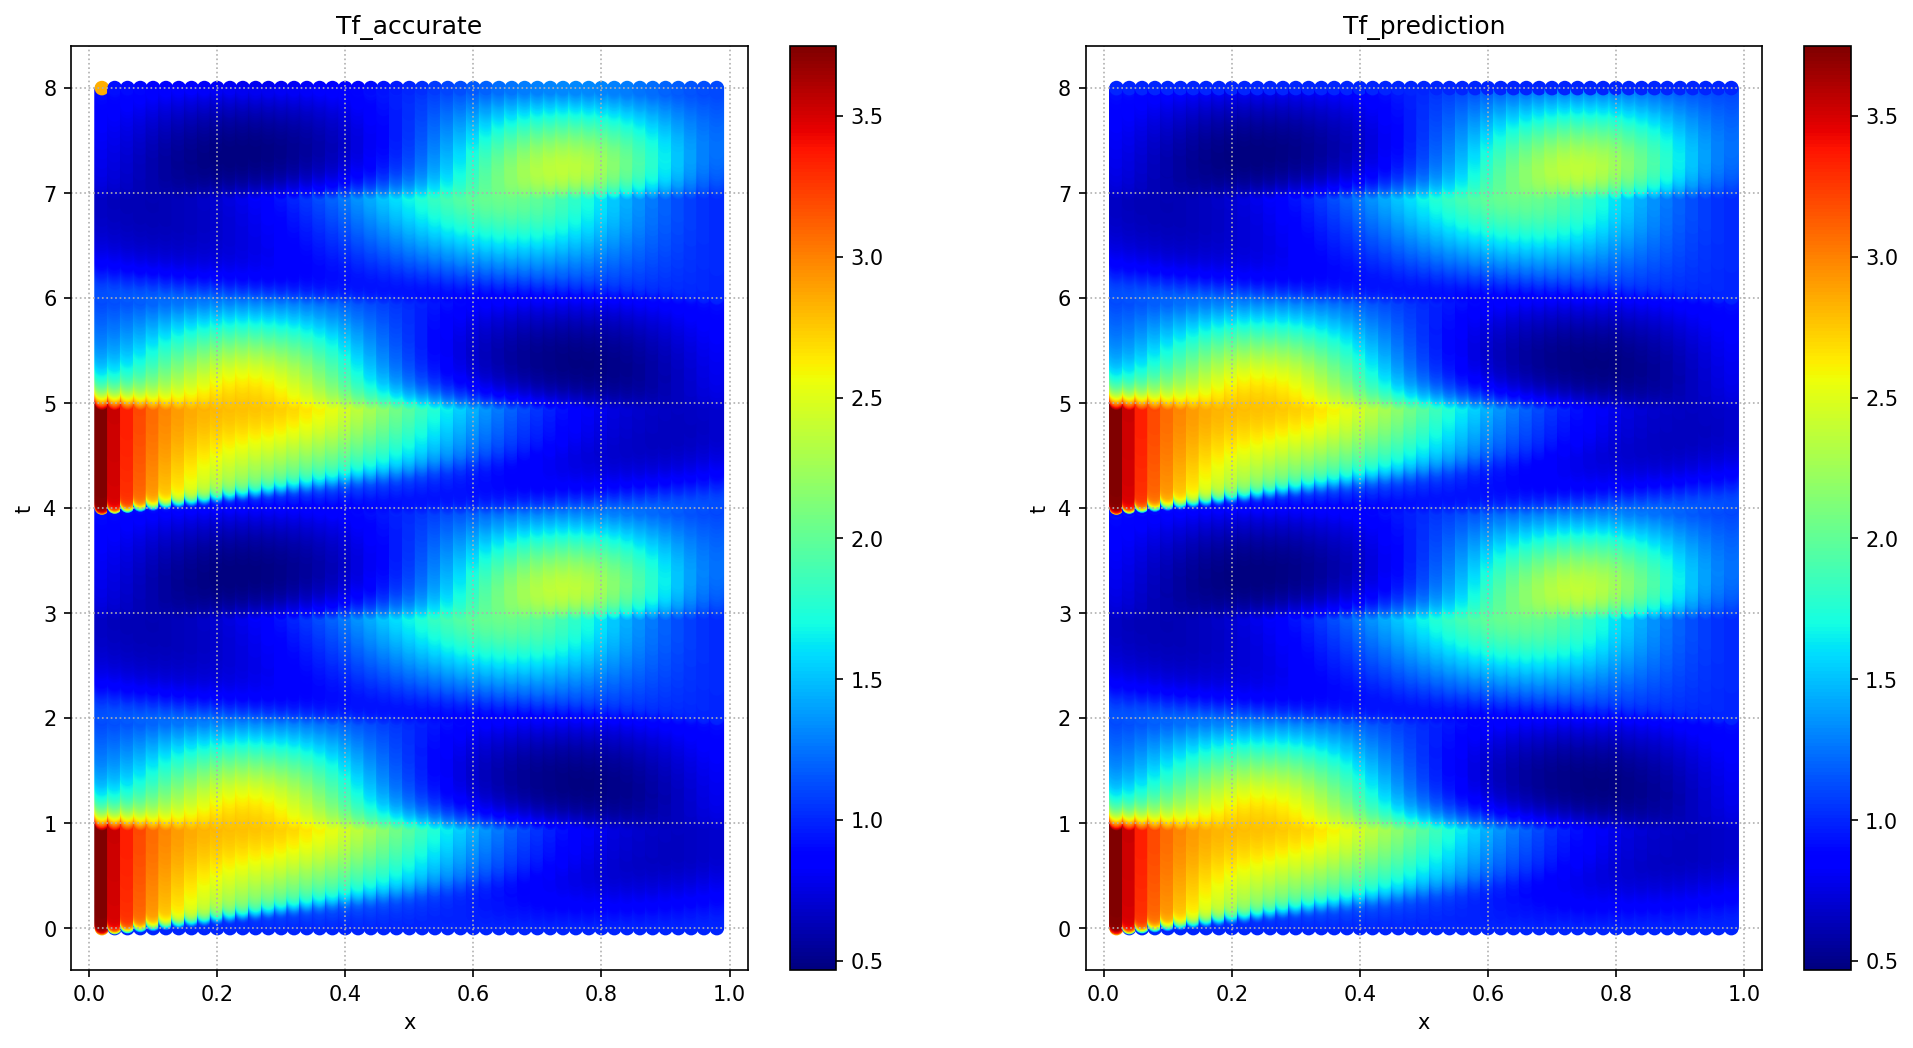

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(coord[:,:].reshape(-1,), time[:,:].reshape(-1,), c=value[:,:].reshape(-1), cmap="jet")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(coord[:,:].reshape(-1,), time[:,:].reshape(-1,), c=FDopt.pred_Tf[1:-1,1:].detach().numpy().reshape(-1),cmap="jet")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Tf_accurate")
axs[1].set_title("Tf_prediction")
plt.show()

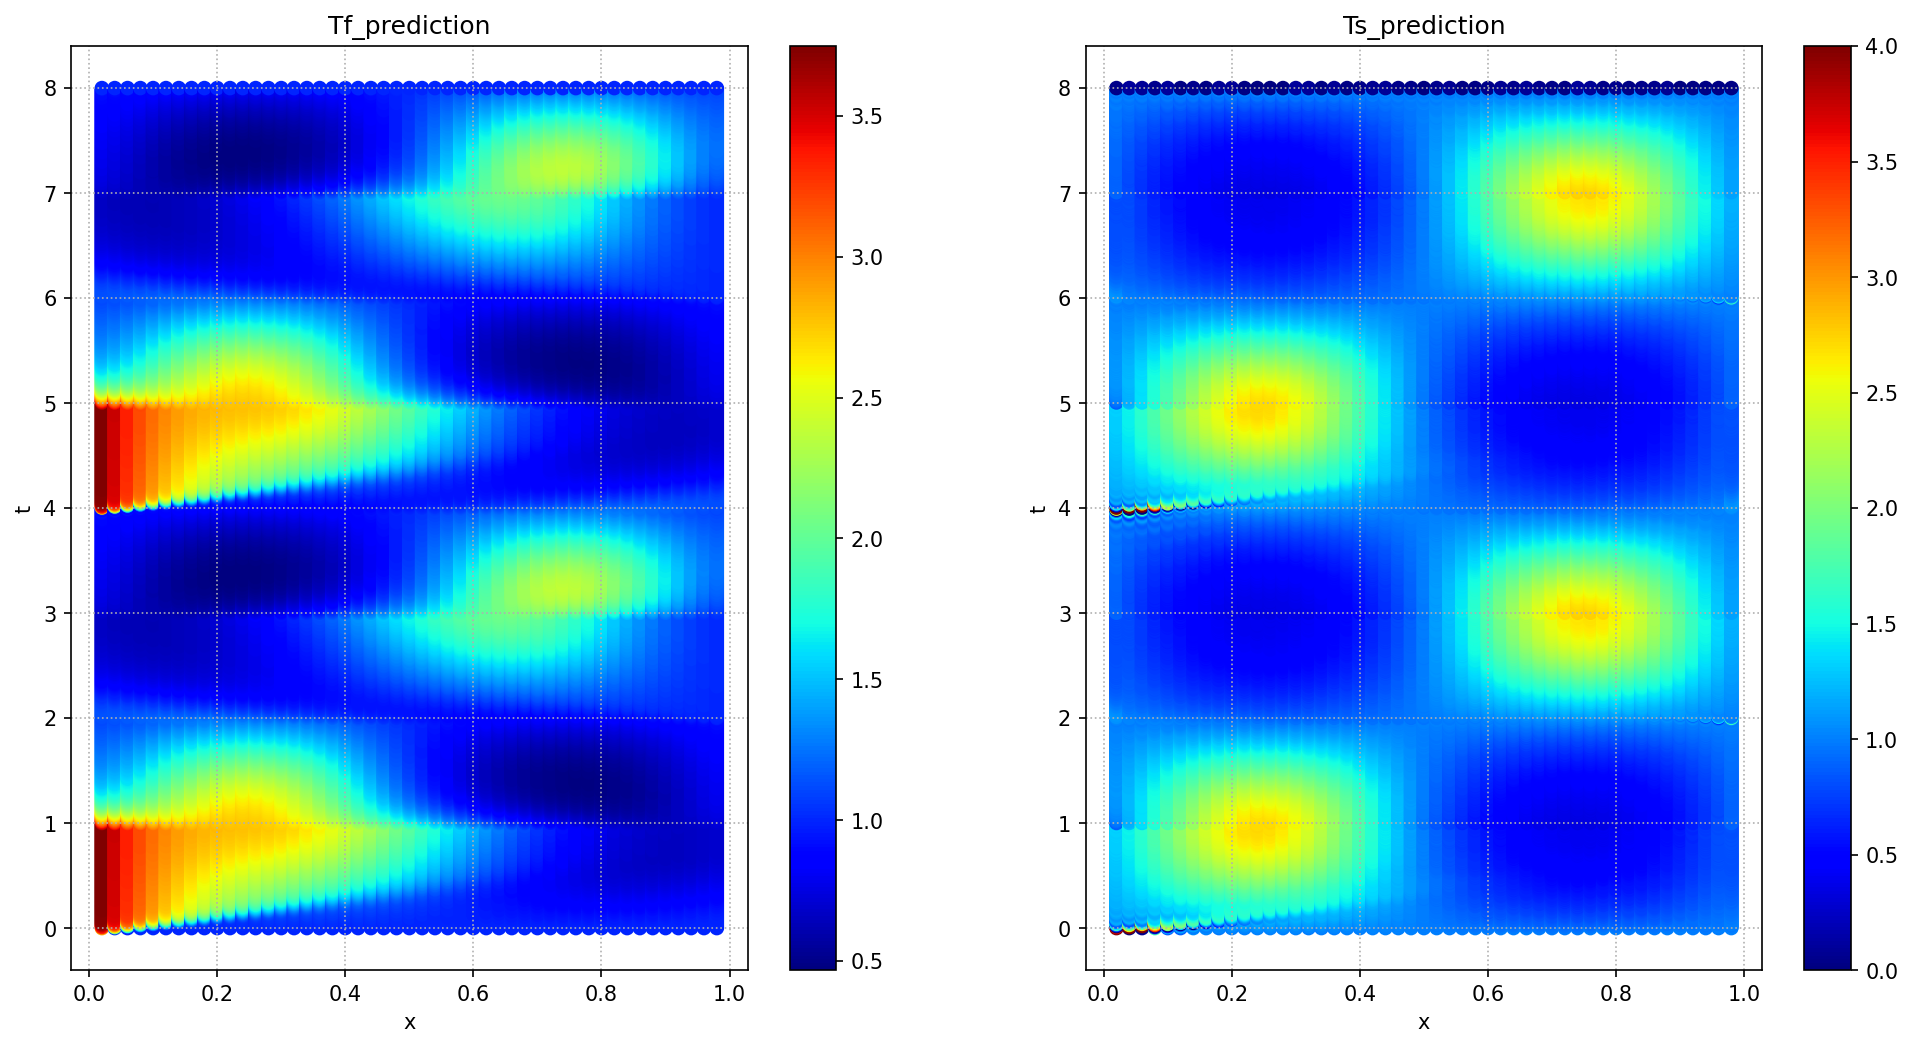

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(coord[:,:].reshape(-1,), time[:,:].reshape(-1,), c=FDopt.pred_Tf[1:-1,1:].detach().numpy().reshape(-1), cmap="jet")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(coord[:,:].reshape(-1,), time[:,:].reshape(-1,), c=torch.clamp(FDopt.pred_Ts(),0,4).detach().numpy().reshape(-1),cmap="jet")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Tf_prediction")
axs[1].set_title("Ts_prediction")
plt.show()

In [18]:
Result = torch.zeros(len(time.reshape(-1,).detach().numpy()),3)
Result[:,0] = time.reshape(-1,)
Result[:,1] = coord.reshape(-1,)
Result[:,2] = torch.clamp(FDopt.pred_Ts(),0,4).detach().reshape(-1,)
np.savetxt('result_FD.txt', Result,delimiter=',',header='t,x,ts')